In [ ]:
import pandas as pd
import numpy as np

In [ ]:
!pip install Keras-Preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.1 MB/s eta 0:00:00


In [ ]:
# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle

# Keras
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, Bidirectional
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2


# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
df = pd.read_csv('/content/drive/MyDrive/Dataset/last_dataset.csv')
df.head()

Mounted at /content/drive


,comment_text,toxic,threat,obscene,religious
0,"অয় ভাই,লজ্জাবতী লতা_____ হেতেরে গে দিয়া চুম্মা।",1,0,1,0
1,"অসভ্য,",1,0,0,0
2,অসুবিধা নাই। নিজেরা দুর্নিতি করে সহযোগিদের ফা...,1,0,1,0
3,"অারিপ্পার পুটকিতে বাল গজুক অার নাই গজুক, অাজ ...",1,0,1,0
4,আইভি সাথে নির্বাচন করতে হলে খালেদা জিয়া লাগবে...,1,0,1,0


In [ ]:
len(df)

20284

In [ ]:
print('Average Article length: ', df.comment_text.str.split().str.len().mean())
print('Stdev Article length: ', df.comment_text.str.split().str.len().std())

Average Article length:  17.12596134884638
Stdev Article length:  24.609793278208564


In [ ]:
cols = df.columns
cols = list(df.columns)
mesh_Heading_categories = cols[1:]
num_labels = len(mesh_Heading_categories)
print('Mesh Labels Root Class: "\n"',mesh_Heading_categories)
print("\n")
print('Number of Labels: ' ,num_labels)

Mesh Labels Root Class: "
" ['toxic', 'threat', 'obscene', 'religious']


Number of Labels:  4


In [ ]:
%%time

counts = []
for mesh_Heading_category in mesh_Heading_categories:
    counts.append((mesh_Heading_category, df[mesh_Heading_category].sum()))
df_count = pd.DataFrame(counts, columns=['Root Label', 'number of Abstract'])
df_count

CPU times: user 2.21 ms, sys: 0 ns, total: 2.21 ms
Wall time: 5.13 ms


,Root Label,number of Abstract
0,toxic,9870
1,threat,2100
2,obscene,9013
3,religious,8880


In [ ]:
# Cleaning Data [Remove unncessary symbols]
def cleaning_documents(articles):
      '''
      This function will clean the news articles by removing punctuation marks and stopwords.

      Args:
      articles: a news text(str)

      returns:
      news: clean text (str)
      '''
      # news = articles.replace('\n',' ')
      news = re.sub('[^\u0980-\u09FF]',' ',str(articles)) #removing unnecessary punctuation
      # stopwords removal
      stp = open('/content/drive/MyDrive/Dataset/stopwords-bn.txt','r',encoding='utf-8').read().split()
      result = news.split()
      news = [word.strip() for word in result if word not in stp ]
      news =" ".join(news)
      return news

In [ ]:
cleaning_documents(df)

'অয় ভাই লজ্জাবতী লতা হেতেরে গে দিয়া চুম্মা অসভ্য অসুবিধা নিজেরা দুর্নিতি সহযোগিদের ফা অারিপ্পার পুটকিতে বাল গজুক অার গজুক অাজ আইভি সাথে নির্বাচন খালেদা জিয়া লাগবে হ্লার পুত তুই হ্লার পুত দিলি দিনটাই খারাপ হ্লার পুতের বাপে মন অয় কম দামি কন্ডম ইউজ করতো হ্লার মাইয়া নিজেরে শো অফ করানোর লাইগে নাস্তিক ্তর বাপের গায়ে জর'

In [ ]:
def text_to_word_list(text):
    text = text.split()
    return text

def replace_strings(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\u00C0-\u017F"          #latin
                           u"\u2000-\u206F"          #generalPunctuations
                               
                           "]+", flags=re.UNICODE)
    english_pattern=re.compile('[a-zA-Z0-9]+', flags=re.I)
    #latin_pattern=re.compile('[A-Za-z\u00C0-\u00D6\u00D8-\u00f6\u00f8-\u00ff\s]*',)
    
    text=emoji_pattern.sub(r'', text)
    text=english_pattern.sub(r'', text)

    return text

def remove_punctuations(my_str):
    # define punctuation
    punctuations = '''````£|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰⚽️✌�￰৷￰'''
    
    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char

    # display the unpunctuated string
    return no_punct



def joining(text):
    out=' '.join(text)
    return out

def preprocessing(text):
    out=remove_punctuations(replace_strings(text))
    return out

In [ ]:
df['comment_text'] = df.comment_text.apply(lambda x: preprocessing(str(x)))

In [ ]:
import keras

In [ ]:
train1, test1 = train_test_split(df,random_state=42, test_size=0.2)
training_sentences = []
testing_sentences = []



train_sentences=train1['comment_text'].values
train_labels=train1[['toxic','threat','obscene', 'religious']].values
for i in range(train_sentences.shape[0]): 
    #print(train_sentences[i])
    x=str(train_sentences[i])
    training_sentences.append(x)
    
training_sentences=np.array(training_sentences)





test_sentences=test1['comment_text'].values
test_labels=test1[['toxic','threat','obscene', 'religious']].values
print("new shape:"+str(test_labels.shape))
for i in range(test_sentences.shape[0]): 
    x=str(test_sentences[i])
    testing_sentences.append(x)
    
testing_sentences=np.array(testing_sentences)

print("new shape2:"+str(train_labels.shape))

# train_labels=keras.utils.to_categorical(train_labels)


# test_labels=keras.utils.to_categorical(test_labels)
print("Training Set Length: "+str(len(train1)))
print("Testing Set Length: "+str(len(test1)))
print("training_sentences shape: "+str(training_sentences.shape))
print("testing_sentences shape: "+str(testing_sentences.shape))
print("train_labels shape: "+str(train_labels.shape))
print("test_labels shape: "+str(test_labels.shape))

new shape:(4057, 4)
new shape2:(16227, 4)
Training Set Length: 16227
Testing Set Length: 4057
training_sentences shape: (16227,)
testing_sentences shape: (4057,)
train_labels shape: (16227, 4)
test_labels shape: (4057, 4)


In [ ]:
vocab_size = 25000
embedding_dim = 300
max_length = 300
trunc_type='post'
oov_tok = "<OOV>"

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
print(len(word_index))
print("Word index length:"+str(len(tokenizer.word_index)))
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)


test_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(test_sequences,maxlen=max_length)

36202
Word index length:36202


In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.python.keras import regularizers

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
with tf.device('/gpu:0'):
    model= Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(Conv1D(200, kernel_size=3, activation = "leaky_relu"))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dense(50, activation='leaky_relu'))
    model.add(Dense(50, activation='leaky_relu'))
    model.add(Flatten())
    #l2 regularizer
    model.add(Dense(100,kernel_regularizer=regularizers.l2(1e-12),activation="leaky_relu"))
    model.add(Dense(4, activation='sigmoid'))
    #sgd= SGD(lr=0.0001,decay=1e-6,momentum=0.9,nesterov=True)
    adam=Adam(learning_rate=0.005,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False)
    model.summary()
    model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          7500000   
                                                                 
 conv1d (Conv1D)             (None, 298, 200)          180200    
                                                                 
 bidirectional (Bidirectiona  (None, 298, 128)         135680    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 298, 128)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 50)                6

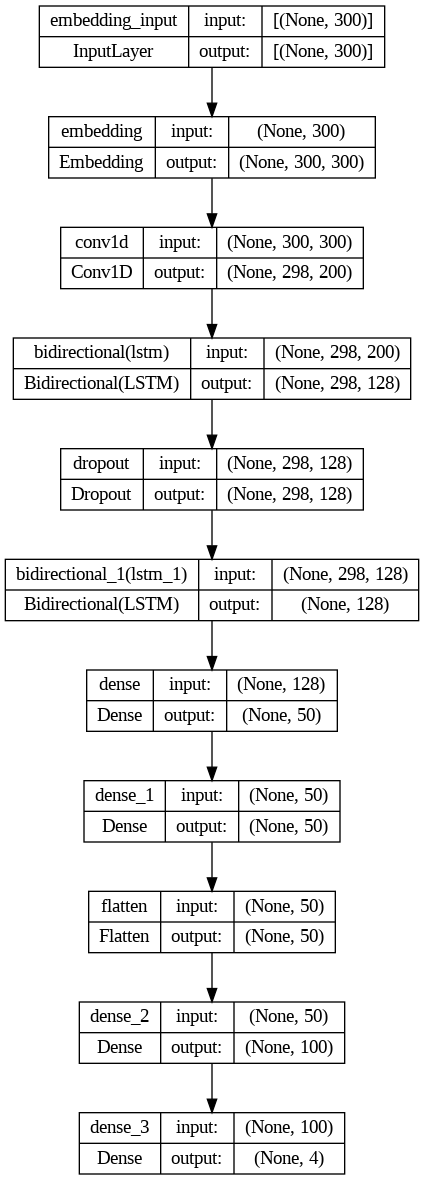

In [ ]:
#plot the vulgar detection model architecture
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='toxic_detection_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='toxic_detection_model_plot.png')

In [ ]:
history=model.fit(padded,train_labels,epochs=5,batch_size=256,validation_data=(testing_padded,test_labels),use_multiprocessing=True, workers=8)

Epoch 1/5
64/64 [==============================] - 40s 321ms/step - loss: 0.4236 - accuracy: 0.5716 - val_loss: 0.3070 - val_accuracy: 0.5600
Epoch 2/5
64/64 [==============================] - 17s 268ms/step - loss: 0.2372 - accuracy: 0.7017 - val_loss: 0.2937 - val_accuracy: 0.8146
Epoch 3/5
64/64 [==============================] - 16s 251ms/step - loss: 0.1670 - accuracy: 0.8542 - val_loss: 0.3072 - val_accuracy: 0.7570
Epoch 4/5
64/64 [==============================] - 16s 249ms/step - loss: 0.1172 - accuracy: 0.9013 - val_loss: 0.3147 - val_accuracy: 0.8324
Epoch 5/5
64/64 [==============================] - 15s 231ms/step - loss: 0.0843 - accuracy: 0.9261 - val_loss: 0.3343 - val_accuracy: 0.8353


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


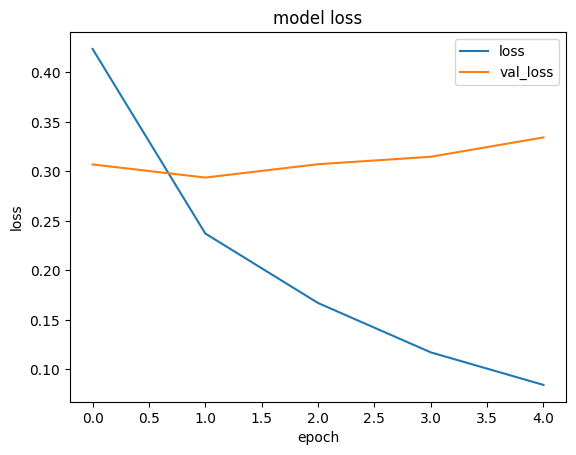

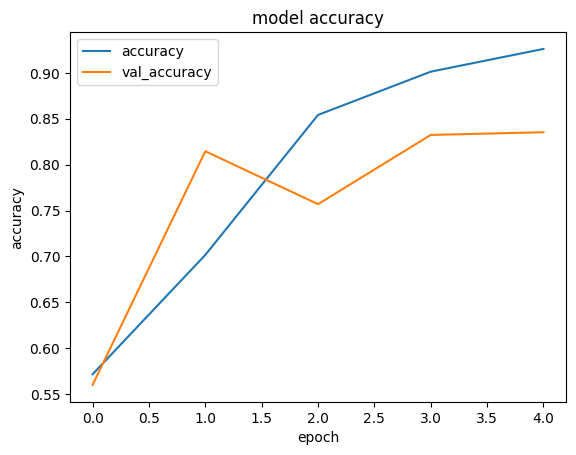

In [ ]:
print(history.history.keys())
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'])
plt.show()

accuracy = history.history['accuracy']
val_accuracy= history.history['val_accuracy']
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [ ]:
#accuracy calculation
loss_and_metrics = model.evaluate(padded,train_labels,batch_size=8)
print("The train accuracy is: "+str(loss_and_metrics[1]))
loss_and_metrics = model.evaluate(testing_padded,test_labels,batch_size=8)
print("The test accuracy is: "+str(loss_and_metrics[1]))

2029/2029 [==============================] - 35s 17ms/step - loss: 0.0601 - accuracy: 0.9443
The train accuracy is: 0.9442903995513916
508/508 [==============================] - 9s 17ms/step - loss: 0.3343 - accuracy: 0.8353
The test accuracy is: 0.8353463411331177


In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Assuming you have the true labels for the test set stored in 'test_labels' and the model predictions stored in 'predictions'

# Get predicted probabilities from the model
predictions = model.predict(testing_padded)

# Convert predicted probabilities to binary labels
predicted_labels = np.zeros_like(predictions)
predicted_labels[np.arange(len(predictions)), predictions.argmax(1)] = 1

# Define the class labels
class_labels = ['toxic', 'threat', 'obscene', 'religious']

# Generate classification report
report = classification_report(test_labels, predicted_labels, target_names=class_labels)

# Print the report
print(report)


127/127 [==============================] - 3s 24ms/step
              precision    recall  f1-score   support

       toxic       0.88      0.81      0.84      1960
      threat       0.73      0.59      0.65       414
     obscene       0.92      0.15      0.26      1783
   religious       0.91      0.83      0.87      1781

   micro avg       0.88      0.60      0.72      5938
   macro avg       0.86      0.60      0.66      5938
weighted avg       0.89      0.60      0.66      5938
 samples avg       0.88      0.68      0.74      5938

